In [1]:
import sys
sys.path.append('../src/')

In [1]:
import os.path as osp

import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid

from torch_geometric import seed_everything

import numpy as np
import pandas as pd

import networkx as nx
from torch_geometric.utils.convert import from_networkx

from tqdm import tqdm

from model_grn import GRNGNN ,prediction_dgl
from explainer_grn import PaGELink
from metrics import deletion_curve_edges, deletion_curve_features, linear_area_score
from utils_eval import ws_graph_model, sbm_graph_model, get_computation_graph_as_nx
from utils_eval import get_explanation
from plotting import visualize_explanation_grn

from torch_geometric.utils import k_hop_subgraph

from matplotlib import pyplot as plt
import seaborn as sb

/home/younggun0816/anaconda3/envs/GRNXAI/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
from data_grn_processing import load_grn_dataset, load_grn_dataset_dgl
from collections import defaultdict
from utils import src_tgt_khop_in_subgraph
import pickle
from pathlib import Path

In [3]:
sb.set_theme(context='paper', style='white', font_scale=1.5, palette=None)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 0


In [5]:
# DGL 그래프에서 feature dimension 가져오기 (feat이 아닌 모든 ndata 속성 사용)
def get_in_dim(mp_g):
    """
    DGL 그래프에서 모든 노드 feature의 총 차원을 계산하는 함수
    """
    node_feats = []
    for key in mp_g.ndata.keys():  # 모든 노드 feature 속성 확인
        feat = mp_g.ndata[key]  # 해당 feature 텐서 가져오기
        if len(feat.shape) == 2:  # (num_nodes, feature_dim) 형태일 경우만 추가
            node_feats.append(feat.shape[1])
    
    if not node_feats:
        raise ValueError("No valid node features found in graph! Check ndata.")

    return sum(node_feats)  # 모든 feature 차원을 더해서 총 in_dim 반환


In [ ]:

processed_g = load_grn_dataset_dgl("datasets","Ecoli1_basic_graph", val_ratio=0.2, test_ratio=0.3)[1]
mp_g, train_pos_g, train_neg_g, val_pos_g, val_neg_g, test_pos_g, test_neg_g = [g.to(device) for g in processed_g]

try:
    in_dim = get_in_dim(mp_g)
except KeyError:
    raise ValueError("Graph does not contain 'feat' in node features. Ensure features are properly assigned.")


model = GRNGNN(in_channels=in_dim, hidden1_channels=128, hidden2_channels=64, out_channels=32, dec='dot_sum', af_val='F.silu', num_layers=4, epoch=20, aggr='sum', var='ChebConv')
state = torch.load(f'saved_models/basic_data_Ecoli1_InSilicoSize100_model.pth', map_location='cuda')
model.load_state_dict(state) 

pagelink = PaGELink(model, 
                    lr=0.01,
                    alpha=1.0, 
                    beta=1.0, 
                    num_epochs=20,
                    log=True,
                    af_val='F.silu').to(device)


In [ ]:

test_src_nids, test_tgt_nids = test_pos_g.edges()
comp_graphs = defaultdict(list)
comp_g_labels = defaultdict(list)

i = 7
# Get the k-hop subgraph
src_nid, tgt_nid = test_src_nids[i], test_tgt_nids[i]
comp_g_src_nid, comp_g_tgt_nid, comp_g, comp_g_feat_nids, comp_g_eids = src_tgt_khop_in_subgraph( src_nid,
                                                                                     tgt_nid,
                                                                                            mp_g,
                                                                                            k=2)

with torch.no_grad():
    pred, pos = prediction_dgl(model, comp_g, af_val='F.silu', dec='dot_sum')

print(f" comp_g_eids : {comp_g_eids}")

# Extract edges from the graph
edge_index = torch.stack(comp_g.edges(), dim=0).cpu().numpy()
src_tgt_pair = np.array([comp_g_src_nid.cpu().numpy(), comp_g_tgt_nid.cpu().numpy()]).reshape(2, 1)
# Check if the prediction contains this specific edge
mask = np.all(edge_index == src_tgt_pair, axis=0)

print(f"mask: {mask}")
print(f"pred.shape: {pred[0].shape}")
print(f"pred[mask]: {pred[mask]}")
print(f"pred[mask].shape: {pred[mask].shape}")


if mask.sum() > 0 and pred[mask][0]:  # src_nid -> tgt_nid에 대한 예측 값이 1인지 확인
    src_tgt = (int(src_nid), int(tgt_nid))
    comp_graphs[src_tgt] = [comp_g_src_nid, comp_g_tgt_nid, comp_g, comp_g_feat_nids]


print(comp_g)
print(comp_graphs)

mask: [False False False False False False False False False False False False
 False False False False False  True]
pred.shape: ()
pred[mask]: [0]
pred[mask].shape: (1,)
Graph(num_nodes=10, num_edges=18,
      ndata_schemes={'wildtype': Scheme(shape=(1,), dtype=torch.float32), 'id': Scheme(shape=(1,), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'KD': Scheme(shape=(1,), dtype=torch.float32), 'KO': Scheme(shape=(1,), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)})
defaultdict(<class 'list'>, {})


In [9]:
saved_model_name = "basic_data_Ecoli1_InSilicoSize100_model"
eval_explainer_names = ['pagelink']
saved_explanation_dir = "saved_explanations"

explainer = eval_explainer_names[0]
saved_explanation_mask = f'{explainer}_{saved_model_name}_pred_edge_to_comp_g_edge_mask'
saved_file = Path.cwd().joinpath(saved_explanation_dir, saved_explanation_mask)
with open(saved_file, "rb") as f:
    explanation_mask = pickle.load(f)

print(explanation_mask)


{(43, 9): tensor([-0.3943, -0.1814, -1.1273,  0.0619, -0.0515, -0.2472, -0.2656,    -inf,
        -0.1400, -0.4582,    -inf, -0.1548, -0.7125,  0.9660,  0.1329, -0.0785,
         0.5486,  0.5040]), (62, 59): tensor([ 1.1378, -0.3204, -0.2206,  0.0567,  0.0453, -0.1805,  0.4035,    -inf,
         0.3622, -0.3079,  0.0614,    -inf,  0.4641,  0.0414, -0.1678, -0.0406,
         0.9230, -0.8123]), (97, 98): tensor([-0.3452]), (37, 8): tensor([-0.4438,  0.9096, -0.4030,    -inf,    -inf,    -inf]), (45, 21): tensor([-0.9756,  0.1708]), (4, 8): tensor([-0.3105,    -inf,  0.2890,    -inf,    -inf,    -inf]), (84, 3): tensor([ 0.5916, -0.5675,  0.2584,  0.1694]), (65, 64): tensor([ 0.5787, -0.1249]), (92, 94): tensor([ 0.3725,  0.5669, -0.1351,  0.5079,  0.4169]), (43, 62): tensor([-0.0275, -0.1120,  0.3529, -0.4097,  0.4531,  1.0310,    -inf,  0.0907,
        -0.6986,  0.7997,    -inf, -0.3765, -0.0029,  0.1812, -0.3710,  0.3100,
         0.3749, -1.2895]), (4, 3): tensor([-0.7217,  0.0687,   

In [15]:
import dgl
def get_exp_g(g, paths, src_nid, tgt_nid):
    path_eids = []
   
    for path in paths:
        for edge in path :
            # 🔥 `path`는 경로를 이루는 노드 리스트이므로, 최소 2개 이상의 노드가 있어야 함
            if len(edge)< 2:
                print(f"⚠️ Warning: path가 너무 짧아 무시됨! {path}")
                continue  

            # ✅ `path`를 (u, v) 엣지 쌍으로 변환하여 `edge_ids` 찾기
            for i in range(len(edge) - 1):  
                u, v = edge[i], edge[i + 1]

                eids = g.edge_ids(u, v)

                # ✅ eids가 텐서인 경우 리스트로 변환
                if isinstance(eids, torch.Tensor):
                    eids = eids.tolist()
                elif not isinstance(eids, list):
                    eids = [eids]

                path_eids.extend(eids)  # ✅ 경로 엣지를 저장
            
    # ✅ path_eids가 비어 있지 않다면 텐서로 변환
    path_eids = torch.tensor(path_eids, dtype=torch.long) if path_eids else torch.tensor([], dtype=torch.long)

    print(f"Converted path_eids: {path_eids}")  # 디버깅 출력

    exp_g = g

    remove_eids = g.edges(form='eid')
    if path_eids.numel() > 0:  # ✅ 빈 텐서일 경우 예외 처리
        mask = torch.ones(remove_eids.shape, dtype=torch.bool)
        mask[path_eids] = False  # ✅ path_eids에 해당하는 엣지만 유지
        remove_eids = remove_eids[mask]  # ✅ 제거할 엣지만 남기기

    exp_g = dgl.remove_edges(exp_g, remove_eids) # creates a new graph
    exp_g = dgl.compact_graphs(exp_g)

    # Get src and tgt nid in the explanation graph
    # Note: the input graph should have node data dgl.NID
    exp_g_src_nid_in_g = exp_g.ndata[dgl.NID]
    exp_g_src_nid = (exp_g_src_nid_in_g == src_nid).nonzero().view(-1)
    exp_g_tgt_nid = (exp_g_src_nid_in_g == tgt_nid).nonzero().view(-1)

    return exp_g, exp_g_src_nid, exp_g_tgt_nid   

#comp_g_edge_mask_dict = explanation_mask[src_tgt]
# comp_g의 엣지 ID 가져오기
# comp_g_edge_ids = comp_g.edges(form='eid')

# print(f"comp_g_edge_ids : {comp_g_edge_ids}")

# explanation_mask[src_tgt] = explanation_mask[src_tgt].to(comp_g_edge_ids.device)
# comp_g_edge_mask_dict = explanation_mask[src_tgt][comp_g_edge_ids]



# 1. 원본 그래프(mp_g)에서 comp_g의 엣지를 찾기 위해 edge list를 가져옴
mp_edge_index = torch.stack(mp_g.edges(), dim=0).cpu().numpy()  # 전체 그래프의 edge list
comp_edge_index = torch.stack(comp_g.edges(), dim=0).cpu().numpy()  # subgraph(comp_g)의 edge list

# 3. comp_g의 엣지들이 원본 그래프(mp_g)의 어느 위치인지 찾기
comp_g_edge_mask_dict = {}

for i, edge in enumerate(comp_edge_index.T):  # 각 (src, tgt) 쌍을 검사
    print(f"i, edge : {i}, {edge}")
    src, tgt = edge
    print(f" src, tgt : {src}, {tgt}")
    # mp_g에서 해당 엣지의 index 찾기
    mask = (mp_edge_index[0] == src) & (mp_edge_index[1] == tgt)
    print(mask)
    
    if mask.sum() > 0:
        eid = mask.nonzero()[0][0]  # 첫 번째 매칭된 index를 가져옴
        comp_g_edge_mask_dict[i] = explanation_mask[eid]  # explanation_mask에서 해당 값 가져오기

# 4. 결과 출력
print(comp_g_edge_mask_dict)




print(f"comp_g num_edges: {comp_g.num_edges()}")  # 18이 나와야 정상
print(f"comp_g_edge_mask shape: {comp_g_edge_mask_dict.shape}")  # (18,)이 나와야 정상


print(f"src_tgt : {src_tgt}")
print(f"comp_g_edge_mask_dict : {comp_g_edge_mask_dict}")
from explainer_grn import PaGELink
pagelink = PaGELink(model)
paths = pagelink.get_paths(comp_g_src_nid, comp_g_tgt_nid, comp_g, comp_g_edge_mask_dict)



exp_g, exp_g_src_nid, exp_g_tgt_nid = get_exp_g(comp_g, 
                                                paths,
                                                comp_g_src_nid,
                                                comp_g_tgt_nid)

i, edge : 0, [0 2]
 src, tgt : 0, 2
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False Fa

KeyError: np.int64(6)

In [25]:
print(exp_g)
print(comp_g)

Graph(num_nodes=2, num_edges=1,
      ndata_schemes={'wildtype': Scheme(shape=(1,), dtype=torch.float32), 'id': Scheme(shape=(1,), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'KD': Scheme(shape=(1,), dtype=torch.float32), 'KO': Scheme(shape=(1,), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64), 'eweight': Scheme(shape=(), dtype=torch.float32)})
Graph(num_nodes=6, num_edges=6,
      ndata_schemes={'wildtype': Scheme(shape=(1,), dtype=torch.float32), 'id': Scheme(shape=(1,), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'KD': Scheme(shape=(1,), dtype=torch.float32), 'KO': Scheme(shape=(1,), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64), 'eweight': Scheme(shape=(), dtype=torch.float32)})


In [26]:
from torch_geometric.utils import to_networkx

comp_g = comp_g.cpu()
nx_comp_g = dgl.to_networkx(comp_g)

In [27]:
graph_model = "GRN"
model_name = "ChebConv"
decoder = "CosineSimilarity"

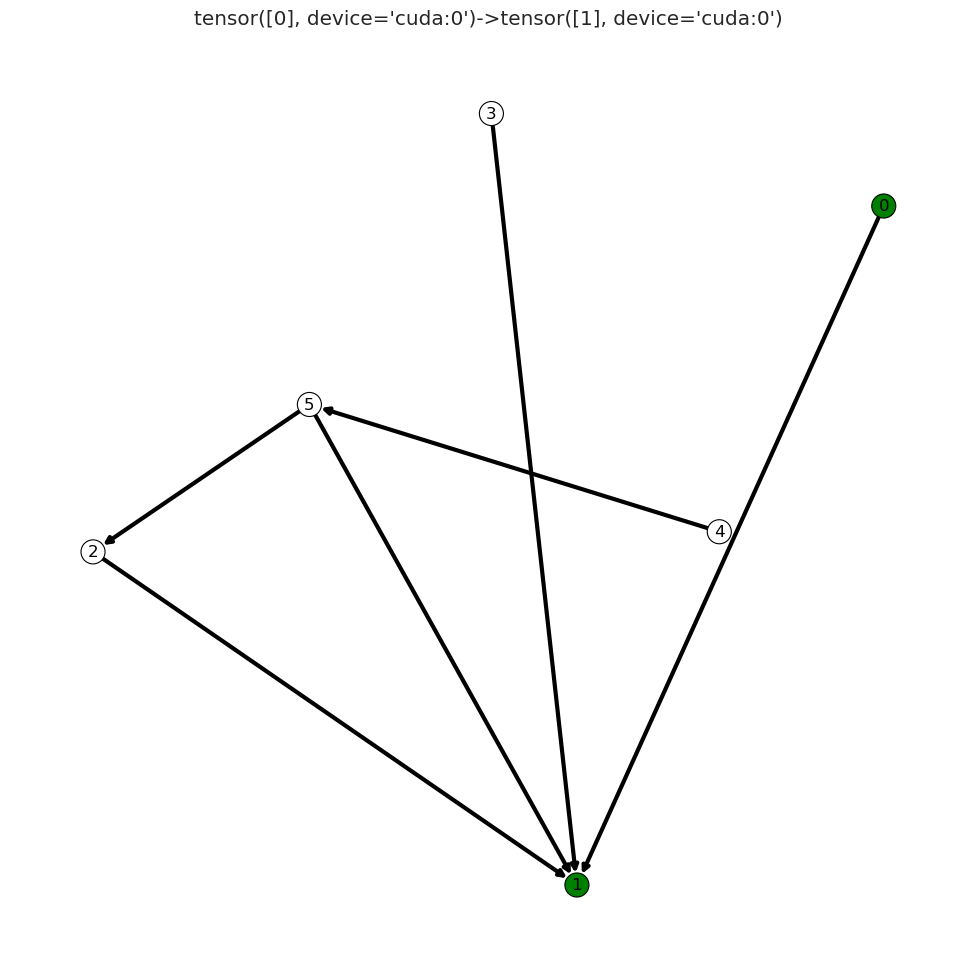

In [28]:
fig = visualize_explanation_grn(nx_comp_g, edge_index, exp_g, exp_g_src_nid, exp_g_tgt_nid)
plt.tight_layout()
plt.savefig(f"./paper/figs/{graph_model}_{model_name}_{explainer}_{decoder}_explanation_example.png")

In [9]:
subset, sub_edge_index, sub_mapping, sub_edge_mask = k_hop_subgraph(
        [source_node, target_node], 
        2, 
        train_data.edge_index)

#  Edges
deletion_curve = deletion_curve_edges(
    model,
    train_data.x,
    sub_edge_index,
    edge_label_index,
    edge_mask[sub_edge_mask],
    sigmoid=sigmoid
)

#  Edges random
deletion_curve_rnd = deletion_curve_edges(
    model,
    train_data.x,
    sub_edge_index,
    edge_label_index,
    edge_mask[sub_edge_mask],
    sigmoid=sigmoid,
    sorting='random'
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:56<00:00,  2.84s/it]


In [10]:
edge_score = linear_area_score(deletion_curve)

In [11]:
edge_score

0.5420408624775718

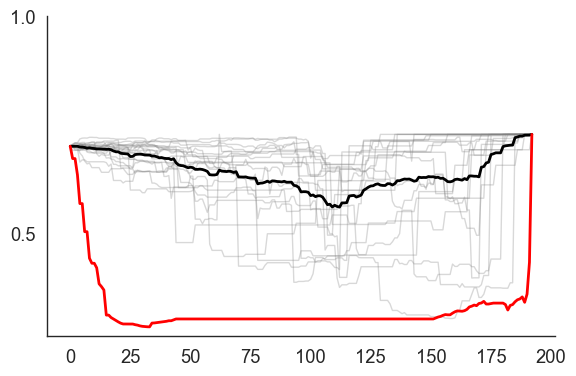

In [12]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(deletion_curve_rnd.T, alpha=.3, c='grey', lw=1)
plt.plot(deletion_curve_rnd.mean(axis=0), c='black', lw=2)
plt.plot(deletion_curve, c='r', lw=2)
ax.set_yticks([0.5, 1])
sb.despine()
plt.tight_layout()

In [13]:
#  Features / Nodes
feature_mean_mask = node_mask.mean(axis=0)
node_mean_mask = node_mask.mean(axis=1)
feature_base_values = train_data.x.mean(dim=0)

feature_deletion_curve = deletion_curve_features(
    model,
    train_data.x,
    sub_edge_index,
    edge_label_index,
    feature_mean_mask,
    feature_base_values,
    sigmoid=sigmoid
)

#  Features / Nodes
feature_mean_mask = node_mask.mean(axis=0)
node_mean_mask = node_mask.mean(axis=1)
feature_base_values = train_data.x.mean(dim=0)

feature_deletion_curve_rnd = deletion_curve_features(
    model,
    train_data.x,
    sub_edge_index,
    edge_label_index,
    feature_mean_mask,
    feature_base_values,
    sigmoid=sigmoid, 
    sorting='random'
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [06:19<00:00, 18.99s/it]


In [14]:
feature_score = linear_area_score(feature_deletion_curve)

In [15]:
feature_score

0.5627308208978637

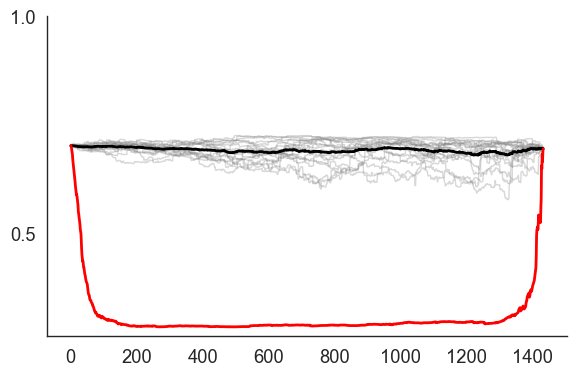

In [16]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(feature_deletion_curve_rnd.T, alpha=.3, c='grey', lw=1)
plt.plot(feature_deletion_curve_rnd.mean(axis=0), c='black', lw=2)
plt.plot(feature_deletion_curve, c='r', lw=2)
ax.set_yticks([0.5, 1])
sb.despine()
plt.tight_layout()